# UC SD Micromasters - Python for Data Science
# Craigslist Used Cars Dataset
## Price Prediction with Decision Tree Regressor 


In [1]:
# import required libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

## Import and read dataset

First, look at downloaded file from https://www.kaggle.com/austinreese/craigslist-carstrucks-data/download.

In [2]:
from subprocess import check_output
print(check_output(["ls", "./data"]).decode("utf8"))

craigslist-carstrucks-data.zip
vehicles.csv



Unzip the file and extract into the data folder.

In [ ]:
# how to from https://www.kaggle.com/mchirico/how-to-read-datasets
import zipfile
Dataset = "craigslist-carstrucks-data"

with zipfile.ZipFile("./data/"+Dataset+".zip","r") as z:
    z.extractall("./data")

Import data as pandas dataframe.

In [2]:
cars_raw = pd.read_csv("./data/vehicles.csv")

In [3]:
# dataframe shape
print("Number of rows:",cars_raw.shape[0])
print()
print("Number of columns",cars_raw.shape[1])

Number of rows: 539759

Number of columns 25


## Preliminary Data Cleaning

Remove unnecessary columns and null values. Let's look at the proportion of non-null values as percent of total number of rows. This will give us an idea of which variables contain the most amount of actual data vs those that are mostly `NULL`.

In [4]:
no_null_prc = (cars_raw.count()/len(cars_raw)).round(2)*100
no_null_prc

id              100.0
url             100.0
region          100.0
region_url      100.0
price           100.0
year            100.0
manufacturer     96.0
model            99.0
condition        56.0
cylinders        60.0
fuel             99.0
odometer         82.0
title_status     99.0
transmission     99.0
vin              58.0
drive            71.0
size             31.0
type             73.0
paint_color      68.0
image_url       100.0
description     100.0
county            0.0
state           100.0
lat              98.0
long             98.0
dtype: float64

Select columns of interest that have greater than 70% of actual data.

In [5]:
cols_to_use = list(no_null_prc[no_null_prc>=70].index)
cols_to_use

['id',
 'url',
 'region',
 'region_url',
 'price',
 'year',
 'manufacturer',
 'model',
 'fuel',
 'odometer',
 'title_status',
 'transmission',
 'drive',
 'type',
 'image_url',
 'description',
 'state',
 'lat',
 'long']

Remove the first 4 columns: these columns only contain the id and other url information. We also remove description, image_url, and location information. We also remove the model and manufacturer columns.

In [6]:
cols_not_needed = list(cars_raw.columns[0:4])
cols_not_needed.extend(['description','image_url','state','lat','long','manufacturer','model'])
cols_not_needed

['id',
 'url',
 'region',
 'region_url',
 'description',
 'image_url',
 'state',
 'lat',
 'long',
 'manufacturer',
 'model']

Lastly, we remove any `na` values and select our features of interest

In [7]:
cars = cars_raw[[name for name in cols_to_use if name not in cols_not_needed]]
cars = cars.dropna()
cars.sample(10)

,price,year,fuel,odometer,title_status,transmission,drive,type
287077,5500,2003.0,gas,107000.0,clean,automatic,rwd,sedan
384521,3000,2005.0,gas,150000.0,clean,manual,rwd,hatchback
125594,16600,2017.0,gas,25354.0,clean,automatic,fwd,sedan
497714,0,2015.0,gas,82994.0,clean,automatic,rwd,SUV
129854,19000,2017.0,gas,41955.0,clean,other,rwd,coupe
328284,13995,2007.0,diesel,348113.0,clean,automatic,4wd,truck
213141,28999,2011.0,diesel,178857.0,clean,automatic,4wd,pickup
452930,0,2017.0,other,7077.0,clean,other,fwd,sedan
427094,16298,2017.0,gas,42018.0,clean,automatic,fwd,sedan
499100,15000,2007.0,gas,160000.0,clean,manual,4wd,SUV


In [8]:
# dataframe shape
print("Number of rows:",cars.shape[0])
print()
print("Number of columns",cars.shape[1])

Number of rows: 302911

Number of columns 8


### Description of the variables:

Here is a breakdown of the variables and their types. In our analysis, `price` will be the predicted variables.

Categorical variables:
- drive
- type
- fuel
- title_status
- transmission
- state

Numerical variables:
- price
- year
- odometer

Date variables:
- year

## Preliminary data exploration and further cleaning

We will now explore the data and determine what further cleaning needs to be done. First, lets look at the distribution of the numeric variables, here is a summary of the median data : 

- Median price is 10,990 while the max value is 4.2 billion!
- Median odometer reading is 94674 mi.
- Median year is 2012

Here are some more additiona statistics.

In [9]:
cars.describe(percentiles=[0.05,0.1,0.5,0.9,0.95]).transpose()

,count,mean,std,min,5%,10%,50%,90%,95%,max
price,302911.0,191389.370987,2.333448e+07,0.0,0.0,900.0,10990.0,28000.0,34900.0,4.198287e+09
year,302911.0,2010.844987,7.058727e+00,1900.0,2000.0,2003.0,2012.0,2017.0,2018.0,2.021000e+03
odometer,302911.0,100539.526382,1.132707e+05,0.0,12933.0,23581.0,93674.0,179000.0,205000.0,1.000000e+07


### Price and Odometer

Remove vehicles with prices and odometer readings that are slightly more than the 90% percentile and less than the 1% percentile. This will get rid of extreme outliers. We will also remove `year` values equal to zero. 

In [10]:
cars = cars[(cars.price<=30000) & 
              (cars.price>1000) & 
              (cars.odometer<=180000) &  
              (cars.odometer>=2000) & 
              (cars.year > 0)]

# dataframe shape
print("Number of rows:",cars.shape[0])
print()
print("Number of columns",cars.shape[1])

Number of rows: 217652

Number of columns 8


Let's look at a plot of a joint histogram using exagonal bins of the price with odometer reading: notice the downward non-linear nature of of the data.

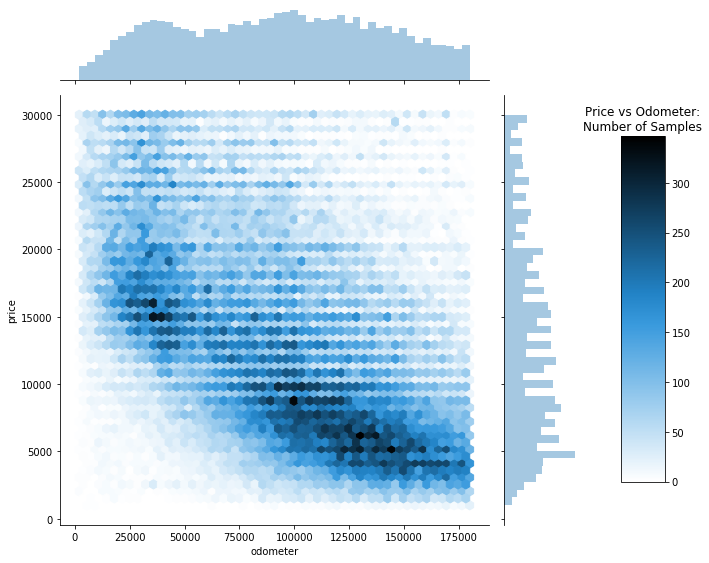

In [11]:
# how to add legend from https://stackoverflow.com/questions/29096632/getting-legend-in-seaborn-jointplot/29909033
hexplot = sns.jointplot("odometer", "price", data=cars,height=12,kind = "hex");
cbar_ax = hexplot.fig.add_axes([.85, .25, .05, .4])  # x, y, width, height
plt.subplots_adjust(left=0.2, right=0.8, top=0.8, bottom=0.2)  # shrink fig so cbar is visible
plt.colorbar(cax=cbar_ax)
plt.title('Price vs Odometer:\nNumber of Samples')
plt.show()

### Transmission

A large majority of values in transmission are laballed as  "other":

In [12]:
cars.transmission.value_counts()

automatic    192228
other         13120
manual        12304
Name: transmission, dtype: int64

We'll assume transmission labeled "other" is automatic:

In [13]:
cars['transmission'] = np.where(cars.transmission == "other","automatic",cars.transmission)

Now let's look at the boxplot of transmission type vs price. Notice that vehicles with an automatic transmission tend to be at slightly higher price:

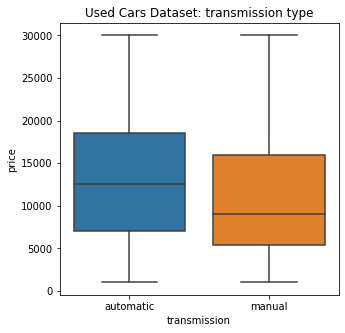

In [14]:
plt.figure(figsize=(5,5))
sns.boxplot(x='transmission',y='price',data=cars).set_title('Used Cars Dataset: transmission type');

### Title Status

A very small number of listings of `title_status` values are either labeled "missing" or "parts only". So we'll remove those variables from the dataset.

In [15]:
cars.title_status.value_counts()

clean         207502
rebuilt         6372
salvage         2217
lien            1455
missing           85
parts only        21
Name: title_status, dtype: int64

In [16]:
# remove 'missing' and 'parts only'
keep = ['clean','rebuilt','salvage','lien']
cars = cars[cars['title_status'].isin(keep)]
# dataframe shape
print("Number of rows:",cars.shape[0])
print()
print("Number of columns",cars.shape[1])

Number of rows: 217546

Number of columns 8


Now let's look a the boxplot of `titlestatus` vs `price`. Interestingly, vehicles with a lien tend to be higher priced. This could be because those vehicles typically are being sold to pay off creditors (banks, dealerships, etc.)

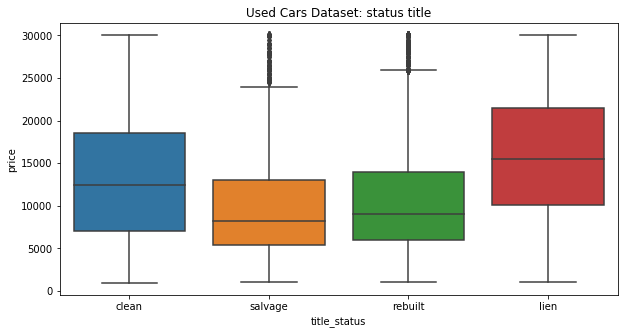

In [17]:
plt.figure(figsize=(10,5))
sns.boxplot(x='title_status',y='price',data=cars).set_title('Used Cars Dataset: status title');

### Fuel Type

Let's take a look at the distribution of `prices` by `fuel` type: notice that diesel-powered vehicles tend to be more expensive, while hybrid-types are the cheapest. Note, howeve, that diesel-powered vehicles could also be larger in general (Think trucks and SUV's), which makes them more expensive.

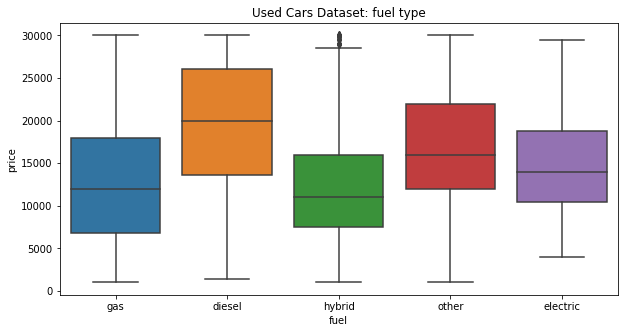

In [18]:
plt.figure(figsize=(10,5))
sns.boxplot(x='fuel',y='price',data=cars).set_title('Used Cars Dataset: fuel type');

Vehicles with fuel type as  "other" can be removed from the analysis since it would be difficult to identify the fuel type to for those vehicles:

In [19]:
cars.fuel.value_counts()

gas         199815
diesel        9689
other         5315
hybrid        2268
electric       459
Name: fuel, dtype: int64

In [20]:
# remove fuel type "other"
cars = cars[~cars['fuel'].isin(['other'])]
# dataframe shape
print("Number of rows:",cars.shape[0])
print()
print("Number of columns",cars.shape[1])

Number of rows: 212231

Number of columns 8


### Year

Lets see the number of vehicles grouped by `year` on a line plot: notice that most vehicles listings are for vehicles of years between the late 90's and early 2020.

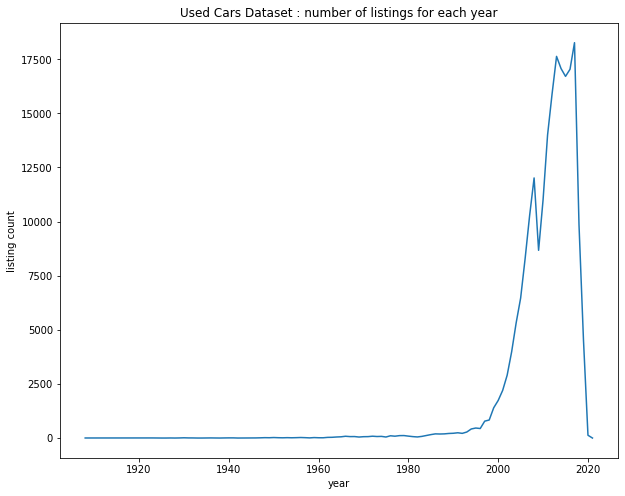

In [21]:
grouped_by_year = cars.groupby('year').count().reset_index()
plt.figure(figsize=(10,8))
ax = sns.lineplot(x='year',y='price',data=grouped_by_year);
ax.set(ylabel="listing count",title='Used Cars Dataset : number of listings for each year');

For this analysis we'll look at listings between 1999 and 2019:

In [22]:
cars = cars[(cars.year>=1999) & (cars.year<=2019)]
# dataframe shape
print("Number of rows:",cars.shape[0])
print()
print("Number of columns",cars.shape[1])

Number of rows: 205263

Number of columns 8


## Vehicle Type

Let's now look at vehicle type. There are quite a few types of vehicles in the data set. However, there are some types that do not occur very often ("bus", "off-road") and other types that could refer to the same vehicle type ("pickup" and "truck", which interestingly have very similar distributions, makin it very possible that those are the same type).

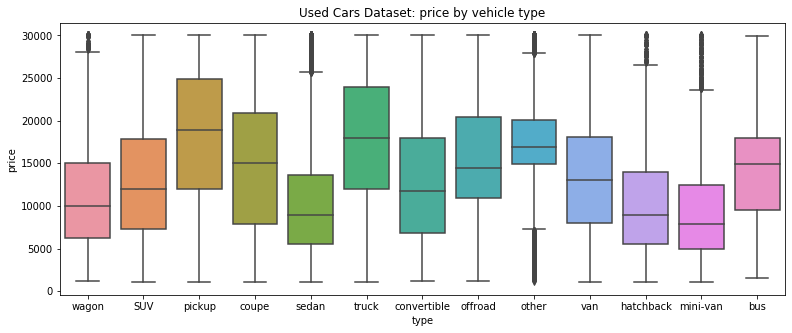

In [23]:
plt.figure(figsize=(13,5))
sns.boxplot(x='type',y='price',data=cars).set_title('Used Cars Dataset: price by vehicle type');

In [24]:
cars.type.value_counts()

sedan          57573
SUV            52793
truck          22989
pickup         22393
coupe          11464
hatchback       8727
other           7896
wagon           7390
van             5385
convertible     4342
mini-van        3828
offroad          310
bus              173
Name: type, dtype: int64

We can remove instances that do not occur very often (type `offroad` and `bus`), as well as `other`. Can also merge the `pickup` and `truck` categories into one: `pickup`. 

In [25]:
# remove type "bus","offroad","other"
cars = cars[~cars['type'].isin(['other','offroad','bus'])]
# change "truck" to "pickup"
cars['type'] = np.where(cars.type == "truck","pickup",cars.type)

In [26]:
cars.type.value_counts()

sedan          57573
SUV            52793
pickup         45382
coupe          11464
hatchback       8727
wagon           7390
van             5385
convertible     4342
mini-van        3828
Name: type, dtype: int64

## Drive Type

Now we'll look at the `drive` variable. In this case, there is a clear difference between all types and also have large number of instances, so there is no further cleaning be done in this case.

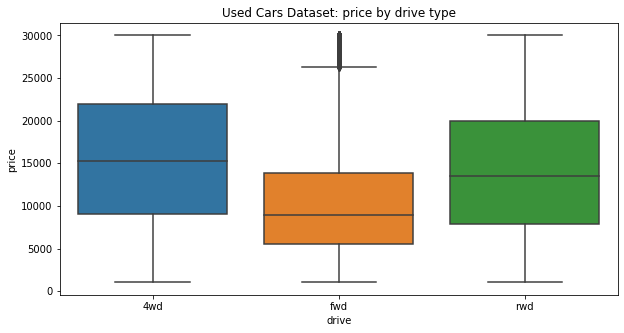

In [27]:
plt.figure(figsize=(10,5))
sns.boxplot(x='drive',y='price',data=cars).set_title('Used Cars Dataset: price by drive type');

In [28]:
cars.drive.value_counts()

4wd    83753
fwd    79820
rwd    33311
Name: drive, dtype: int64

### Clean data

Here is what the data looks like so far (take 10 samples):

In [29]:
cars.sample(10)

,price,year,fuel,odometer,title_status,transmission,drive,type
353668,21345,2018.0,gas,10741.0,clean,automatic,4wd,SUV
288066,9789,2013.0,gas,108629.0,clean,automatic,rwd,coupe
485637,15895,2018.0,gas,14189.0,clean,automatic,fwd,sedan
389003,9995,2010.0,gas,108656.0,clean,automatic,rwd,sedan
265085,4500,2008.0,gas,166472.0,clean,automatic,fwd,sedan
269946,11835,2010.0,gas,128894.0,clean,automatic,4wd,SUV
10947,22999,2019.0,gas,36987.0,clean,automatic,4wd,SUV
384043,25750,2017.0,gas,32818.0,clean,automatic,4wd,SUV
428589,4950,2010.0,gas,129749.0,clean,automatic,rwd,pickup
36874,24900,2010.0,diesel,96837.0,clean,automatic,4wd,pickup


In [30]:
cars.shape

(196884, 8)

## Decision Tree Regression

We are now ready to predict the `price` of a vehicle using a Decision Tree Regression. First we identify the predicted variable.

In [31]:
# load required libraries


In [32]:
# predicted variable
y = cars[['price']].copy()
y.head()

,price
5,12995
6,10995
10,7995
16,12995
17,12995


Now we extract the predictors (feature variables):

In [33]:
# features
X = cars.iloc[:,1:].copy()
X.head()

,year,fuel,odometer,title_status,transmission,drive,type
5,2015.0,gas,85127.0,clean,automatic,4wd,wagon
6,2014.0,gas,112383.0,clean,automatic,fwd,SUV
10,2008.0,gas,162214.0,clean,automatic,fwd,pickup
16,2009.0,gas,146353.0,clean,automatic,4wd,SUV
17,2009.0,gas,146353.0,clean,automatic,4wd,SUV


### Encode Categorical Variables

Since a Decision Tree Regressor requires numberic variables, we'll have to encode the categorical variables with `get_dummies` function from Pandas. This will make each variable either 0 or 1 at the expense of adding a large number of columns (since it will add a column or each category).

In [34]:
cat_columns = ['fuel','title_status','transmission','type','drive']
X_enc = pd.get_dummies(X,columns = cat_columns)
X_enc.sample(6)

,year,odometer,fuel_diesel,fuel_electric,fuel_gas,fuel_hybrid,title_status_clean,title_status_lien,title_status_rebuilt,title_status_salvage,...,type_coupe,type_hatchback,type_mini-van,type_pickup,type_sedan,type_van,type_wagon,drive_4wd,drive_fwd,drive_rwd
296194,2016.0,88200.0,0,0,1,0,1,0,0,0,...,0,0,0,0,1,0,0,0,1,0
507740,2003.0,52964.0,0,0,1,0,1,0,0,0,...,1,0,0,0,0,0,0,0,0,1
396735,2015.0,99271.0,0,0,1,0,1,0,0,0,...,0,0,0,0,1,0,0,0,1,0
491014,2010.0,166000.0,0,0,1,0,1,0,0,0,...,0,0,0,0,1,0,0,0,0,1
75411,2014.0,100412.0,0,0,1,0,1,0,0,0,...,0,0,0,0,1,0,0,0,1,0
81024,2013.0,102405.0,0,0,1,0,1,0,0,0,...,0,0,0,0,1,0,0,1,0,0


In [35]:
X_enc.shape

(196884, 24)

### Perform Training and Testing Split

In [36]:
# split training and testing dataset
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_enc, y, random_state=66,test_size=0.33)

### Fit First Model

In [50]:
# import the regressor 
from sklearn.tree import DecisionTreeRegressor  

# create a regressor object 
regressor = DecisionTreeRegressor(random_state = 66,min_samples_leaf=150)
regressor.fit(X_train, y_train) 

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=None,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=150, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=66, splitter='best')

In [51]:
y_pred = regressor.predict(X_test)
y_pred

array([15444.96137339,  9638.6375    , 18337.95364238, ...,
       11239.67021277,  5664.34895833,  8191.28040541])

In [52]:
print('Training accuracy: ',regressor.score(X_train,y_train))
print('Test Accuracy: ',regressor.score(X_test,y_test))

Training accuracy:  0.747452538412872
Test Accuracy:  0.7408741200142617


### Post-pruning decision trees: Cost Complexity Pruning 

The model generated above may produce good predictions on the training set (as you can see we have a taining score of 0.98), but is likely to overfit the data, leading to poor test set performance (test score of 0.73). In order to mitigte this, we "prun" the large tree based on a tuning parameter $\alpha$, which penalizes a tree with many terminal nodes.

For more information on Cost Complexity Pruning, you can see Sklearn [documentaion](https://scikit-learn.org/stable/modules/tree.html#minimal-cost-complexity-pruning).

In [75]:
# get effective alphas and corresponding inpurities from the model
path = regressor.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

Plotting the alphas vs impurities(except the last alpha corresponding to root node):

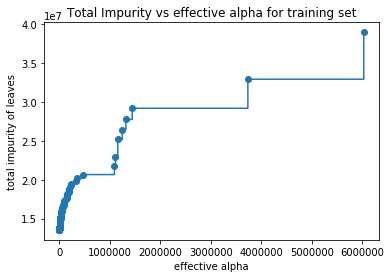

In [76]:
fig, ax = plt.subplots();
ax.plot(ccp_alphas[:-1], impurities[:-1], marker='o', drawstyle="steps-post");
ax.set_xlabel("effective alpha");
ax.set_ylabel("total impurity of leaves");
ax.set_title("Total Impurity vs effective alpha for training set");

In the plot above, the smallest value of $\alpha$ corresponds to the tree with the least inpurity (maximum number of nodes, unpruned). Next, we build a forest of trees with different values of `ccp_alpha` values extracted from `path` in order. The last tree will be the root node ad therefore will be removed.

In [78]:
clfs = []
for ccp_alpha in ccp_alphas:
    clf = DecisionTreeRegressor(random_state = 66,
                                min_samples_leaf=100,
                                ccp_alpha=ccp_alpha)
    clf.fit(X_train, y_train)
    clfs.append(clf)

clfs = clfs[:-1]
ccp_alphas = ccp_alphas[:-1]

We plot how the different values of ccp_alpha influence the number of nodes and depth of the corresponding pruned trees.

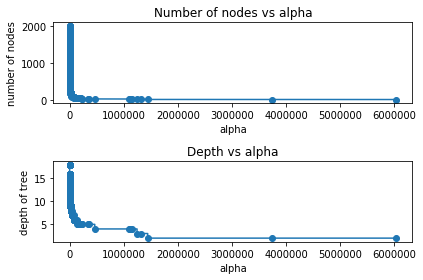

In [81]:
# get node counts and depth
node_counts = [clf.tree_.node_count for clf in clfs]
depth = [clf.tree_.max_depth for clf in clfs]
# plot
fig, ax = plt.subplots(2, 1)
ax[0].plot(ccp_alphas, node_counts, marker='o', drawstyle="steps-post")
ax[0].set_xlabel("alpha")
ax[0].set_ylabel("number of nodes")
ax[0].set_title("Number of nodes vs alpha")
ax[1].plot(ccp_alphas, depth, marker='o', drawstyle="steps-post")
ax[1].set_xlabel("alpha")
ax[1].set_ylabel("depth of tree")
ax[1].set_title("Depth vs alpha")
fig.tight_layout()

In [82]:
train_scores = [clf.score(X_train, y_train) for clf in clfs]
test_scores = [clf.score(X_test, y_test) for clf in clfs]

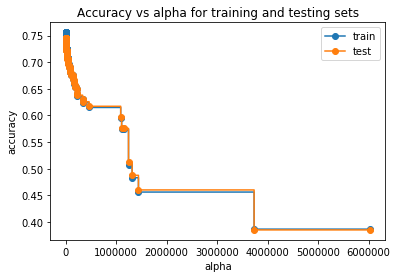

In [83]:
fig, ax = plt.subplots()
ax.set_xlabel("alpha")
ax.set_ylabel("accuracy")
ax.set_title("Accuracy vs alpha for training and testing sets")
ax.plot(ccp_alphas, train_scores, marker='o', label="train",
        drawstyle="steps-post")
ax.plot(ccp_alphas, test_scores, marker='o', label="test",
        drawstyle="steps-post")
ax.legend()
plt.show()